In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CSV
data_csv = "selected_for_annotation_mt_strcture_20250310_MA.csv"
image_dir = "/mnt/d/lding/CLS/mousumiLiuDinner/set1to5_processed_results/Microtubule_GUV-Liu-20250106T211105Z-001/processed_MT/GUV-MT_obj_png_selected_std15"
df = pd.read_csv(data_csv)
df = df.dropna(subset=["filename", "label"])
df["label"] = df["label"].astype(str)

# Split into Train (80%) & Validation (20%)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Define Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, labeled=True):
        self.data = dataframe.copy()
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        if labeled:
            self.label_to_index = {label: idx for idx, label in enumerate(sorted(self.data["label"].unique()))}
            self.data["label"] = self.data["label"].map(self.label_to_index)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.labeled:
            label = int(self.data.iloc[idx, 1])
            return image, label, img_name  # Return image path for saving later
        else:
            return image, img_name  # For unlabeled test data


# Function to initialize different models
def initialize_model(model_name, num_classes):
    if model_name == "efficientnet":
        model = models.efficientnet_b0(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "resnet":
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "convnext":
        model = models.convnext_tiny(pretrained=True)
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError("Unsupported model type")
    return model.to(device)

# Function to generate a CSV file from test images
def generate_test_csv(test_image_dir, test_csv):
    image_files = [f for f in os.listdir(test_image_dir) if f.endswith(".png")]
    test_df = pd.DataFrame(image_files, columns=["filename"])
    test_df.to_csv(test_csv, index=False)
    print(f"Test CSV saved at: {test_csv}")

# Function to load the best trained model
def load_best_model(model_name, model_path, num_classes):
    model = initialize_model(model_name, num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    return model

# Function to classify a test dataset and save images in predicted label folders
def classify_and_save_images(model_name, test_image_dir, model_path, output_dir,label_to_index,result_csv):
    test_csv = "test_data.csv"
    generate_test_csv(test_image_dir, test_csv)
    test_df = pd.read_csv(test_csv)
    test_dataset = CustomDataset(test_df, test_image_dir, transform,labeled=False)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model = load_best_model(model_name, model_path, num_classes=5)
    
    os.makedirs(output_dir, exist_ok=True)

    results = []
    
    with torch.no_grad():
        for images, img_paths in test_dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for img_path, pred in zip(img_paths, preds.cpu().numpy()):                
                pred_label = list(label_to_index.keys())[pred]
                label_folder = os.path.join(output_dir, pred_label)
                os.makedirs(label_folder, exist_ok=True)
                
                img_name = os.path.basename(img_path)
                img_save_path = os.path.join(label_folder, img_name)
                
                img = Image.open(img_path)
                img.save(img_save_path)
                
                results.append({"filename": img_name, "predicted_label": pred_label})
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(result_csv, index=False)
    print(f"Results saved to: {result_csv}")
    
    print(f"Images saved in respective predicted label folders under: {output_dir}")

    # Function to plot images in a 4x8 panel per predicted label
    def plot_images_by_label(image_dir, output_dir, num_rows=4, num_cols=8):
        os.makedirs(output_dir, exist_ok=True)
        predicted_labels = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
        
        for label in predicted_labels:
            label_dir = os.path.join(image_dir, label)
            image_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".png")]
            
            if len(image_files) < num_rows * num_cols:
                continue  # Skip labels with insufficient images
            
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
            fig.suptitle(f"Predicted Label: {label}", fontsize=14)
            
            for i, ax in enumerate(axes.flat):
                img = Image.open(image_files[i])
                ax.imshow(img)
                ax.axis("off")
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.savefig(os.path.join(output_dir, f"{label}_panel.png"))
            plt.close()
        
        # Plot panels of images per predicted label
        plot_images_by_label(output_dir, os.path.join(output_dir, "classified_panels"))

    # Function to plot images in a 4x8 panel per predicted label
    def plot_images_by_label(image_dir, output_dir, num_rows=5, num_cols=10):
        os.makedirs(output_dir, exist_ok=True)
        predicted_labels = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
        
        for label in predicted_labels:
            label_dir = os.path.join(image_dir, label)
            image_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".png")]
            
            if len(image_files) < num_rows * num_cols:
                continue  # Skip labels with insufficient images
            
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
            fig.suptitle(f"Predicted Label: {label}", fontsize=14)
            
            for i, ax in enumerate(axes.flat):
                img = Image.open(image_files[i])
                ax.imshow(img,cmap='gray',vmax=0.8*255,vmin=0)
                ax.axis("off")
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.savefig(os.path.join(output_dir, f"{label}_panel.png"))
            plt.close()

    # Example usage
    classified_image_dir = "classified_images"  # Directory where images are stored in predicted label folders
    panel_output_dir = "classified_panels"  # Output directory for panels
    plot_images_by_label(classified_image_dir, panel_output_dir)

# Example usage to apply model to test set
test_image_dir = "/mnt/d/lding/CLS/mousumiLiuDinner/set1to5_processed_results/Microtubule_GUV-Liu-20250106T211105Z-001/processed_MT/GUV-MT_obj_png_selected_std15"
best_model_path = "saved_models/efficientnet_lr0.0003_wd0.0001_20250318_141830_best/best_model.pth"  # Path to the best model
output_dir = "classified_images"  # Output directory to save classified images
result_csv = "classification_results.csv"  # CSV file to save predictions

label_to_index = {label: idx for idx, label in enumerate(sorted(df["label"].unique()))}
classify_and_save_images("efficientnet", test_image_dir, best_model_path, output_dir, label_to_index,result_csv)


Test CSV saved at: test_data.csv


/home/ldin/anaconda3/envs/pytorch_cuda124/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ldin/anaconda3/envs/pytorch_cuda124/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Results saved to: classification_results.csv
Images saved in respective predicted label folders under: classified_images


In [152]:
# Function to plot images in a 5x10 panel per training class
def plot_training_images_by_label(dataframe, image_dir, output_dir, num_rows=4, num_cols=8):
    os.makedirs(output_dir, exist_ok=True)
    labels = dataframe["label"].unique()
    print(labels)
    for label in labels:
        label_df = dataframe[dataframe["label"] == label]
        image_files = [os.path.join(image_dir, f) for f in label_df["filename"][:num_rows * num_cols]]
        
        if len(image_files) < num_rows * num_cols:
            continue  # Skip labels with insufficient images
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
        fig.suptitle(f"Training Label: {label}", fontsize=14)
        
        for i, ax in enumerate(axes.flat):
            img = Image.open(image_files[i])
            ax.imshow(img,cmap='gray',vmax=0.8*255,vmin=0)
            ax.axis("off")
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(os.path.join(output_dir, f"{label}_panel.png"))
        plt.close()

In [153]:
# Plot training dataset panels

plot_training_images_by_label(df, image_dir, "training_panels")


['Patch' 'Network' 'ZZZ' 'Filaments' 'Cluster']


In [154]:
df

,filename,label
0,1_10 Tau_Tubulin-Date 1-Image10_GUV.TIF_cell02...,Patch
1,1_10 Tau_Tubulin-Date 1-Image3_GUV.TIF_cell03_...,Patch
2,1_10 Tau_Tubulin-Date 1-Image6_GUV.TIF_cell01_...,Network
3,1_10 Tau_Tubulin-Date 1-Image8_GUV.TIF_cell04_...,ZZZ
4,1_10 Tau_Tubulin-Date 1-Image9_GUV.TIF_cell02_...,Network
...,...,...
349,3_10 Tau_Tubulin-Date 5-2 uM tau mt encap guv1...,Patch
350,3_10 Tau_Tubulin-Date 5-2 uM tau mt encap guv8...,Patch
351,3_10 Tau_Tubulin-Date 5-2 uM tau mt encap guv8...,Patch
352,3_10 Tau_Tubulin-Date 5-2 uM tau mt encap guv8...,Patch


In [155]:
df["label"].unique()

array(['Patch', 'Network', 'ZZZ', 'Filaments', 'Cluster'], dtype=object)

In [156]:
# Function to plot images in a 4x8 panel per predicted label
def plot_images_by_label(image_dir, output_dir, num_rows=4, num_cols=8):
    os.makedirs(output_dir, exist_ok=True)
    predicted_labels = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
    
    for label in predicted_labels:
        label_dir = os.path.join(image_dir, label)
        image_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".png")]
        
        if len(image_files) < num_rows * num_cols:
            continue  # Skip labels with insufficient images
        
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))
        fig.suptitle(f"Predicted Label: {label}", fontsize=14)
        
        for i, ax in enumerate(axes.flat):
            img = Image.open(image_files[i])
            ax.imshow(img)
            ax.axis("off")
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(os.path.join(output_dir, f"{label}_panel.png"))
        plt.close()

# Example usage
classified_image_dir = "classified_images"  # Directory where images are stored in predicted label folders
panel_output_dir = "classified_panels"  # Output directory for panels
plot_images_by_label(classified_image_dir, panel_output_dir)

In [157]:
test_csv = "classification_results_con_date.csv"
df = pd.read_csv(test_csv)

df_filtered = df[df['predicted_label'] != 'ZZZ']



In [158]:
import shutil

data_dir = "/mnt/d/lding/CLS/mousumiLiuDinner/set1to5_processed_results/Microtubule_GUV-Liu-20250106T211105Z-001/processed_MT/GUV-MT_obj_tiff_selected_std15"
target_dir = "/mnt/d/lding/CLS/mousumiLiuDinner/non_ZZZ_tiffs"
os.makedirs(target_dir,exist_ok=True)


In [170]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import tifffile
# Load results
image_root = data_dir

guv_sizes = []

for _, row in df.iterrows():
    pred_label = str(row["predicted_label"])
    filename = row["filename"]
    filename = filename.replace('.png','.tif')
    image_path = os.path.join(image_root, filename)

    if not os.path.exists(image_path):
        guv_sizes.append(None)
        continue

    # Load and convert image to grayscale
    img = tifffile.imread(image_path)
    img_np = np.array(img)

    # Compute content size: number of pixels > 0
    content_size = np.sum(img_np > 0.0773)  # You can adjust the threshold
    diameter = 2*np.sqrt(content_size/np.pi)
    guv_sizes.append(diameter)

# Add to DataFrame and save
df["GUV_size"] = guv_sizes

df.to_csv("classification_results_with_size.csv", index=False)
print("Saved: classification_results_with_size.csv")


Saved: classification_results_with_size.csv


In [175]:
df["GUV_dimater_micron"] = np.ceil(df["GUV_size"]*0.2355)
df["GUV_group"] = np.ceil(df["GUV_dimater_micron"]/7).clip(upper=4)
group_labels = {1: "0~7", 2: "7~14", 3: "14~21",4:">21"}
df["GUV_diameter"] = df["GUV_group"].replace(group_labels)

/tmp/ipykernel_1936366/2075356055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GUV_dimater_micron"] = np.ceil(df["GUV_size"]*0.2355)
/tmp/ipykernel_1936366/2075356055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["GUV_group"] = np.ceil(df["GUV_dimater_micron"]/7).clip(upper=4)
/tmp/ipykernel_1936366/2075356055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [176]:
# for i in range(len(df_filtered)):
#     filename = df_filtered.iloc[i].filename    
#     tiff_filename = filename.replace('.png', '.tif')
#     src = os.path.join(data_dir, tiff_filename)
#     dst = os.path.join(target_dir, tiff_filename)
#     shutil.copyfile(src, dst)

In [ ]:
df_123 = df[df['date']<=3]

<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1936366/3803256065.py:61: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel('GUV diameter($\mu$m) \n\n Concentration 1/10')
/tmp/ipykernel_1936366/3803256065.py:62: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('GUV diameter($\mu$m) \n\n Concentration 2/10')
/tmp/ipykernel_1936366/3803256065.py:63: SyntaxWarning: invalid escape sequence '\m'
  ax[2].set_xlabel('GUV diameter($\mu$m) \n\n Concentration 3/10')


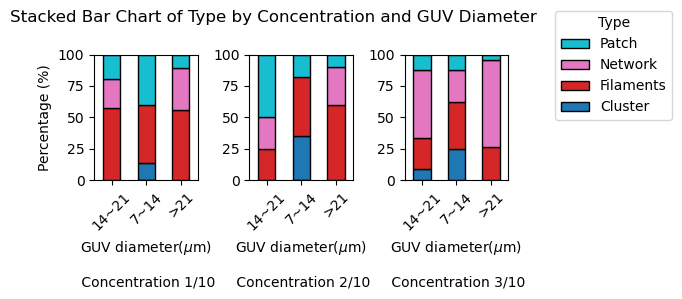

In [178]:
import pandas as pd
import matplotlib.pyplot as plt

df_filtered = df[df['predicted_label'] != 'ZZZ']
df_filtered = df_filtered[df_filtered['concentration'] == 1]

# Count occurrences of each class per feature
count_df = df_filtered.groupby(['GUV_diameter', 'predicted_label']).size().unstack(fill_value=0)

# Convert to percentages (normalize rows to sum to 100%)
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# Create figure and axis
fig, ax = plt.subplots(1,3,figsize=(5, 3))

# Plot 100% stacked bar chart
percentage_df.plot(kind='bar', stacked=True, colormap='tab10', edgecolor='black', ax=ax[0])

ax[0].set_ylabel('Percentage (%)')
# ax[0].set_title('Stacked Bar Chart of Type by Concentration')
ax[0].set_ylim(0, 100)  # Ensure the y-axis represents 100%

desired_order = ['Patch','Network', 'Filaments','Cluster'  ]
handles, labels = ax[0].get_legend_handles_labels()
ordered_handles = [handles[labels.index(l)] for l in desired_order]
fig.legend(ordered_handles, desired_order, title="Type",bbox_to_anchor=(1.05, 1), loc='upper left')


df_filtered = df[df['predicted_label'] != 'ZZZ']
df_filtered = df_filtered[df_filtered['concentration'] == 2]

# Count occurrences of each class per feature
count_df = df_filtered.groupby(['GUV_diameter', 'predicted_label']).size().unstack(fill_value=0)

# Convert to percentages (normalize rows to sum to 100%)
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# Plot 100% stacked bar chart
percentage_df.plot(kind='bar', stacked=True, colormap='tab10', edgecolor='black', ax=ax[1])

fig.suptitle('Stacked Bar Chart of Type by Concentration and GUV Diameter')
ax[1].set_ylim(0, 100)  # Ensure the y-axis represents 100%


df_filtered = df[df['predicted_label'] != 'ZZZ']
df_filtered = df_filtered[df_filtered['concentration'] == 3]

# Count occurrences of each class per feature
count_df = df_filtered.groupby(['GUV_diameter', 'predicted_label']).size().unstack(fill_value=0)

# Convert to percentages (normalize rows to sum to 100%)
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# Plot 100% stacked bar chart
percentage_df.plot(kind='bar', stacked=True, colormap='tab10', edgecolor='black', ax=ax[2])
ax[2].set_ylim(0, 100)  # Ensure the y-axis represents 100%
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='center')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='center')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, ha='center')

ax[0].set_xlabel('GUV diameter($\mu$m) \n\n Concentration 1/10')
ax[1].set_xlabel('GUV diameter($\mu$m) \n\n Concentration 2/10')
ax[2].set_xlabel('GUV diameter($\mu$m) \n\n Concentration 3/10')
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
ax[2].legend().set_visible(False)
# fig.supxlabel('Concentration')
plt.tight_layout()  # Adjust layout to fit everything properly
plt.show()


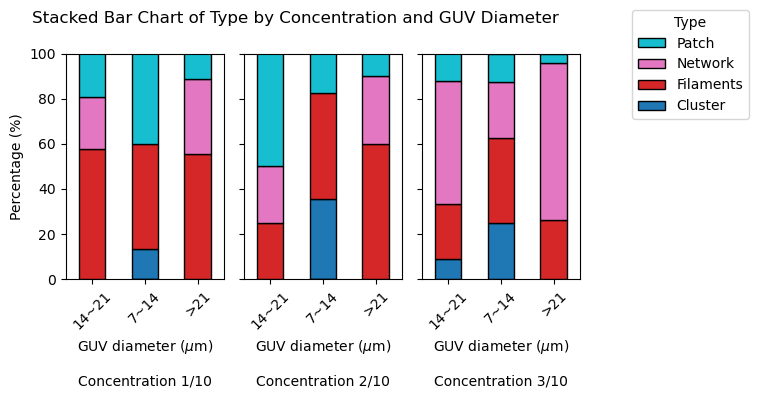

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter out unwanted label
df_filtered = df[df['predicted_label'] != 'ZZZ']

# Parameters
concentrations = [1, 2, 3]
colors = 'tab10'
desired_order = ['Patch', 'Network', 'Filaments', 'Cluster']
n_subplots = len(concentrations)

# Create figure
fig, ax = plt.subplots(1, n_subplots, figsize=(2 * n_subplots, 4), sharey=True)

for i, conc in enumerate(concentrations):
    sub_df = df_filtered[df_filtered['concentration'] == conc]

    # Count and normalize
    count_df = sub_df.groupby(['GUV_diameter', 'predicted_label']).size().unstack(fill_value=0)
    percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

    # Plot
    percentage_df.plot(
        kind='bar',
        stacked=True,
        colormap=colors,
        edgecolor='black',
        ax=ax[i]
    )
    
    ax[i].set_ylim(0, 100)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='center')
    ax[i].set_xlabel(f'GUV diameter ($\\mu$m)\n\nConcentration {conc}/10')
    ax[i].legend().set_visible(False)

# Common settings
ax[0].set_ylabel('Percentage (%)')
fig.suptitle('Stacked Bar Chart of Type by Concentration and GUV Diameter')

# Legend (in desired order)
handles, labels = ax[0].get_legend_handles_labels()
ordered_handles = [handles[labels.index(l)] for l in desired_order]
fig.legend(ordered_handles, desired_order, title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [166]:
percentage_df

predicted_label,Cluster,Filaments,Network,Patch
GUV_diameter,,,,
7~14,30.000000,10.000000,5.000000,55.000000
>14,43.018868,10.188679,28.301887,18.490566


In [167]:
count_df

predicted_label,Cluster,Filaments,Network,Patch
GUV_diameter,,,,
7~14,24,8,4,44
>14,114,27,75,49


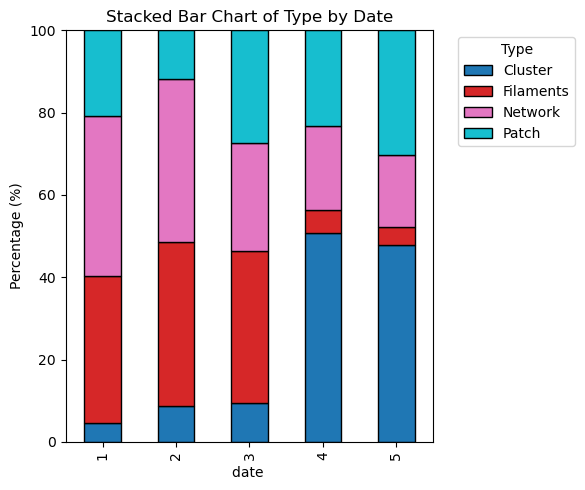

In [168]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each class per feature
count_df = df_filtered.groupby(['date', 'predicted_label']).size().unstack(fill_value=0)

# Convert to percentages (normalize rows to sum to 100%)
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Plot 100% stacked bar chart
percentage_df.plot(kind='bar', stacked=True, colormap='tab10', edgecolor='black', ax=ax)

# Move the legend outside the plot
ax.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Labels and title
plt.xlabel('date ')
plt.ylabel('Percentage (%)')
plt.title('Stacked Bar Chart of Type by Date')
plt.ylim(0, 100)  # Ensure the y-axis represents 100%

plt.tight_layout()  # Adjust layout to fit everything properly
plt.show()


In [169]:
count_df

predicted_label,Cluster,Filaments,Network,Patch
date,,,,
1,3,24,26,14
2,6,27,27,8
3,8,31,22,23
4,288,32,115,132
5,76,7,28,48
